In [ ]:
import random
import networkx as nx
import numpy as np
from tqdm import tqdm
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from collections import defaultdict
from gensim.models import Word2Vec
#from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import roc_auc_score

import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pipeline

### Data Loader

We need to load networks into memory. Usually networks are organized as pairs of nodes. And sometimes different edges have different weights. Hence, we use networkx.DiGraph to store such structure information and attributes.

In [ ]:
def load_data(file_name): #convert file to input: a true_edges list
    """
    read edges from an edge file
    """
    edges = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        user_id, friends = row["user_id"], eval(row["friends"])
        for friend in friends:
            # add each friend relation as an edge
            edges.append((user_id, friend))
    edges = sorted(edges)
    
    return edges

def load_test_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    scores = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        edges.append((row["src"], row["dst"]))
    edges = sorted(edges)
    
    return edges

def generate_false_edges(true_edges, num_false_edges=5): #gen "num_false_edges" non-linked edges 
    """
    generate false edges given true edges //negative sampling
    """
    #why? to add more labeled (false) input data, not just true edge -> model can train both T,F instead of only T
    nodes = list(set(chain.from_iterable(true_edges)))
    N = len(nodes)
    true_edges = set(true_edges)
    false_edges = set()
    
    while len(false_edges) < num_false_edges:
        # randomly sample two different nodes and check whether the pair exist or not
        src, dst = nodes[int(np.random.rand() * N)], nodes[int(np.random.rand() * N)] #source, destination
        if src != dst and (src, dst) not in true_edges and (src, dst) not in false_edges:
            false_edges.add((src, dst))
    false_edges = sorted(false_edges)
    print("number of nodes:", N, ",true edges:", len(true_edges), ",false edges:", len(false_edges))

    return false_edges

def construct_graph_from_edges(edges): #convert input (true_edges list) into a graph
    """
    generate a directed graph object given true edges
    DiGraph documentation: https://networkx.github.io/documentation/stable/reference/classes/digraph.html
    """
    # convert a list of edges {(u, v)} to a list of edges with weights {(u, v, w)}
    edge_weight = defaultdict(float)
    for e in edges:
        edge_weight[e] += 1.0 #edges appear more -> more weights
    weighed_edge_list = list()
    weight_list = []
    for e in sorted(edge_weight.keys()):
        weighed_edge_list.append((e[0], e[1], edge_weight[e]))
        weight_list.append(edge_weight[e])
        
    weights = np.asarray(weight_list)
    print(f"edges have mean weights {weights.mean()} with std {weights.std()}")
    graph = nx.DiGraph()
    graph.add_weighted_edges_from(weighed_edge_list)
    
    print("number of nodes:", graph.number_of_nodes())
    print("number of edges:", graph.number_of_edges())
    
    return graph

### Random Walk Generator

Random walk generators or random walkers yield random walks that contain both local and higher-order neighborhood information. However, naive non-uniform sampling is very slow, which requires O(n) time complexity. Here alias sampling can reduce the time complexity to O(1) with O(n) space. If you are interested, please see the following blog.

In [ ]:
def alias_setup(probs): #input: set of probs to find next node (1st-order) or edge (2nd-order)
    """
    compute utility lists for non-uniform sampling from discrete distributions.
    details: https://lips.cs.princeton.edu/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int)

    smaller = list() #probs<1/K
    larger = list()  #probs>1/K
    for kk, prob in enumerate(probs):
        q[kk] = K * prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q #maybe this is for alias sampling

def get_alias_node(graph, node): #1st-order: every node has same probs -> sore as nodes
    """
    get the alias node setup lists for a given node.
    """
    # get the unnormalized probabilities with the first-order information
    unnormalized_probs = list()
    for nbr in graph.neighbors(node):
        unnormalized_probs.append(graph[node][nbr]["weight"]) #edge from node to neigh weight
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs
        
    return alias_setup(normalized_probs) #list of probs
    
def get_alias_edge(graph, src, dst, p=1, q=1):  #2nd-order, dst=destination: each node: each neighbor has prob -> store as edges
    """
    get the alias edge setup lists for a given edge.
    """
    # get the unnormalized probabilities with the second-order information
    unnormalized_probs = list()
    for dst_nbr in graph.neighbors(dst):
        if dst_nbr == src: # distance is 0
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/p)
        elif graph.has_edge(dst_nbr, src): # distance is 1
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"])
        else: # distance is 2
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/q)
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs #list of probs

    return alias_setup(normalized_probs)

def preprocess_transition_probs(graph, p=1, q=1):
    """
    preprocess transition probabilities for guiding the random walks.
    """
    alias_nodes = dict() #each nodes get list(neibor nodes probs) for 1st-order
    for node in graph.nodes():
        alias_nodes[node] = get_alias_node(graph, node)

    alias_edges = dict() #each edge(to retain curr_node and previous node as well): get list(neibor edges probs) for 2nd-order 
    for edge in graph.edges():
        alias_edges[edge] = get_alias_edge(graph, edge[0], edge[1], p=p, q=q)

    return alias_nodes, alias_edges #nodes for 1st-order, edges for 2nd-order

The difference between DeepWalk and node2vec is how to generate random walks. The former only consider the first-order information while the latter also involves the second-order information.

In [ ]:
def alias_draw(J, q): #J: (pointer)list of nodes/edges, q:?
    """
    draw sample from a non-uniform discrete distribution using alias sampling.
    """
    K = len(J)

    kk = int(np.floor(np.random.rand() * K)) #int in (0,K-1)
    if np.random.rand() < q[kk]: #what is q?
        return kk
    else:
        return J[kk] #return a node(1st-order), or an edge(2nd-order)


# helper function to generate the long random walk as desired
def fallback(walk, fetch_last_num=1): #used when walk can generate more -> fallback and find another way
    if len(walk) > fetch_last_num:
        walk.pop()
        fetched = []
        for i in range(fetch_last_num):
            fetched.append(walk[-1-i])
        return walk, fetched
    else:
        return [], [None for _ in range(fetch_last_num)]

def generate_first_order_random_walk(graph, alias_nodes, 
                                     walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the first order information.
    max_trials: set the max trials to be one for standard random walk. Larger max_trails will make the generated biased.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    cur = start_node
    num_tried = 0
    
    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0: # if we can sample next nodes
            # sample the next node based on alias_nodes
            cur = cur_nbrs[alias_draw(*alias_nodes[cur])] #generate the next node
            walk.append(cur)
        else: # if we can't do that
            num_tried += 1
            if num_tried >= max_trails:
                break

            walk, fetched = fallback(walk, fetch_last_num=1)
            cur = fetched[0]
            if len(walk) == 0: # if falls back to the empty walk
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
    ########## end ##########

    if verbose: 
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk
    
def generate_second_order_random_walk(graph, alias_nodes, alias_edges, 
                                      walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the second order information.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    
    prev = None
    cur = start_node
    num_tried = 0

    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0:
            if prev is None:
                # sample the next node based on alias_nodes
                prev, cur = cur, cur_nbrs[alias_draw(*alias_nodes[cur])] #borrow 1st-order for the 1st step
            else:
                # sample the next node based on alias_edges
                prev, cur = cur, cur_nbrs[alias_draw(*alias_edges[(prev, cur)])]
            walk.append(cur)
        else:
            num_tried += 1
            if num_tried >= max_trails:
                break
            walk, (cur, prev) = fallback(walk, fetch_last_num=2)
            if len(walk) == 0:
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
                prev = None
    ########## end ##########
    if verbose: 
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk

### Network Embedding Algorithms

build_deepwalk() and build_node2vec() are the same but the 1st uses 1st-order walf, 2nd uses 2nd-order walk

In [ ]:
def build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10):
    """
    build a deepwalk model
    """
    print("building a DeepWalk model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()  #list of equal-length random walks

    # generate random walks
    for walk_iter in range(num_walks): #gen random walks for each node num_walks' times
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_first_order_random_walk(
                graph, alias_nodes, walk_length=walk_length, start_node=node))

    #list of walk lengths    
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    #list of random walks ~ list of sentences -> use Word2vec

    # train a skip-gram model for these walks
    #model = Word2Vec(walks, vector_size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), epochs=10)
    model = Word2Vec(walks, size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), iter=10) #sg: skip-gram

    print("training time: %.4f" % (time.time()-st))
    
    return model

def build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10, window_size=3):
    """
    build a node2vec model
    """
    print("building a node2vec model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_second_order_random_walk(
                graph, alias_nodes, alias_edges, walk_length=walk_length, start_node=node))
            
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0    
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    # train a skip-gram model for these walks
    #model = Word2Vec(walks, vector_size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), epochs=10)
    model = Word2Vec(walks, size=node_dim, window=window_size, min_count=0, sg=1, workers=os.cpu_count(), iter=10)
    print("training time %.4f" % (time.time()-st))
    
    return model

### Scorer

In [ ]:
def get_cosine_sim(model, u, v):  #similarity function
    """
    get the cosine similarity between two nodes
    """
    try:
        u = model.wv[u]
        v = model.wv[v]
        return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    except:
        return 0.5

def get_auc_score(model, true_edges, false_edges):
    """
    get the auc score
    """
    y_true = [1] * len(true_edges) + [0] * len(false_edges)
    
    y_score = list()
    for e in true_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    for e in false_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1]))
    #calculate AUC for each label, average 
    return roc_auc_score(y_true, y_score)  #average = "macro" by default i.e. unweighted mean

def write_pred(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)

def write_valid_ans(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)

### Try them over a Real-life Network


####Notes
Test edges might not be in the graph \
Valid edges is extracted from full graph \
-> in the original graph \
Rmk: test set !~~ valid set

Firstly, we need to load edges into memory and use the networkx.DiGraph structure to store the graph.

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/COMP4332/Project 2/data'
train_file = os.path.join(data_dir,"train.csv")
valid_file = os.path.join(data_dir,"valid.csv")
test_file = os.path.join(data_dir,"test.csv")

np.random.seed(0)
train_edges = load_data(train_file)
graph = construct_graph_from_edges(train_edges)
valid_edges = load_data(valid_file)
false_edges = generate_false_edges(train_edges+valid_edges, 40000-len(valid_edges)) #40000=#false+#valid
test_edges = load_test_data(test_file)

edges have mean weights 1.0 with std 0.0
number of nodes: 8343
number of edges: 100000
number of nodes: 8496 ,true edges: 119267 ,false edges: 20733


In [ ]:
df = pd.read_csv(train_file)
print(type(df["friends"][0]), df["friends"][0], df["friends"][0][:5])
print(type(eval(df["friends"][0])), eval(df["friends"][0])[0] )


<class 'str'> ['FFFeLM5rk29RZn6FmGlHYQ', 'PFNZVn73upq3oZDG2KnAqA'] ['FFF
<class 'list'> FFFeLM5rk29RZn6FmGlHYQ


In [ ]:
print(type(train_edges), len(train_edges), len(valid_edges), len(false_edges), len(test_edges))
print(train_edges[:2])

print(type(graph))
print(len(graph))
print(list(graph.nodes())[:2])

<class 'list'> 100000 19267 20733 40000
[('--UOvCH5qEgdNQ8lzR8QYQ', 'FFFeLM5rk29RZn6FmGlHYQ'), ('--UOvCH5qEgdNQ8lzR8QYQ', 'PFNZVn73upq3oZDG2KnAqA')]
<class 'networkx.classes.digraph.DiGraph'>
8343
['--UOvCH5qEgdNQ8lzR8QYQ', 'FFFeLM5rk29RZn6FmGlHYQ']


After that, we can use preprocess transition probabilities with the help of alias sampling.

#Graph visualization (***)

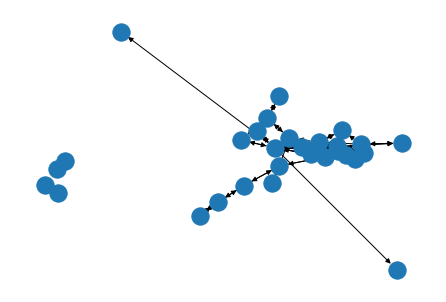

In [ ]:
from random import sample
#index = sample(range(8343),30)
sub = graph.subgraph( list(graph.nodes())[ :30 ] )
nx.draw(sub, with_labels = False)

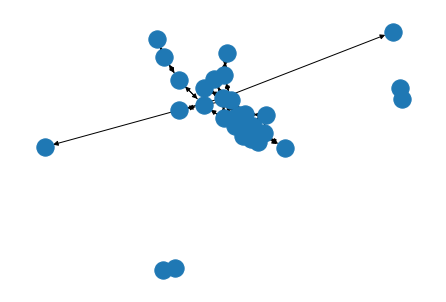

In [ ]:
nx.draw_spring(sub, with_labels = False)

In [ ]:
# Helper function for visualization.
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Visualization function for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

In [ ]:
G = graph
type(G)

networkx.classes.digraph.DiGraph

Graph info

In [ ]:
try: 
  nx.diameter(G)
except:
  print("has loop")
print(nx.density(G))

has loop
0.0014368372247052206


In [ ]:
print(graph.is_directed())
print("graph has {} nodes".format(graph.number_of_nodes()))
print("graph has {} edges".format(graph.number_of_edges()))
node = list(graph.nodes())[9]
print(node)
print(list(graph.neighbors(node)))

#print("Node 0 has the attributes {}".format(graph.nodes[node]))
#graph.graph["Name"] = "Bar"

print("Node {} has degree {}".format(node, graph.degree[node]))
for neighbor in graph.neighbors(node):
  print("Node {} has neighbor {}".format(node, neighbor))

#edge
#edge_0_1_attr = G.edges[(0, 1)]


True
graph has 8343 nodes
graph has 100000 edges
8H6X6GhJhYkcNHjuBjOU4w
['-0HhZbPBlB1YZx3BhAfaEA', 'hkSiQAfl6w3882JJQzRTlQ', 'l_eDRCfkLcaiZzl2T9qJdA', 'qewG3X2O4X6JKskxyyqFwQ']
Node 8H6X6GhJhYkcNHjuBjOU4w has degree 11
Node 8H6X6GhJhYkcNHjuBjOU4w has neighbor -0HhZbPBlB1YZx3BhAfaEA
Node 8H6X6GhJhYkcNHjuBjOU4w has neighbor hkSiQAfl6w3882JJQzRTlQ
Node 8H6X6GhJhYkcNHjuBjOU4w has neighbor l_eDRCfkLcaiZzl2T9qJdA
Node 8H6X6GhJhYkcNHjuBjOU4w has neighbor qewG3X2O4X6JKskxyyqFwQ


In [ ]:
print(list(G.nodes)[:3])
print(list(G.edges)[:2])
print(list(G.degree)[:3]) #degree of each node
print(sorted(G.degree, key=lambda x:x[1], reverse = True)[:3])
print(sorted(G.degree, key=lambda x:x[1])[:3])

['--UOvCH5qEgdNQ8lzR8QYQ', 'FFFeLM5rk29RZn6FmGlHYQ', 'PFNZVn73upq3oZDG2KnAqA']
[('--UOvCH5qEgdNQ8lzR8QYQ', 'FFFeLM5rk29RZn6FmGlHYQ'), ('--UOvCH5qEgdNQ8lzR8QYQ', 'PFNZVn73upq3oZDG2KnAqA')]
[('--UOvCH5qEgdNQ8lzR8QYQ', 6), ('FFFeLM5rk29RZn6FmGlHYQ', 85), ('PFNZVn73upq3oZDG2KnAqA', 51)]
[('dIIKEfOgo0KqUfGQvGikPg', 776), ('RBZ_kMjowV0t6_nv2UKaDQ', 728), ('qewG3X2O4X6JKskxyyqFwQ', 726)]
[('-2CgKa8YdvPzPB16XSA8Fg', 1), ('pjrpGQtM2Au3hJfypEWA0g', 1), ('-6itJehE4X9y4Zx8uNEFwA', 1)]


In [ ]:
sub = graph.subgraph( list(graph.nodes())[ :50 ] )

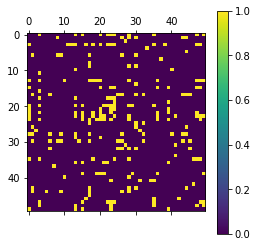

In [ ]:
plt.matshow(nx.to_numpy_matrix(sub))
plt.colorbar()
plt.show()

In [ ]:
pos = nx.random_layout(sub, dim=2, seed=1)
print(pos)

{'wnO99pBbGqwqOoTQM25iCw': array([0.417022 , 0.7203245], dtype=float32), 'UsmTxWbobLsI6WR1Db0W7A': array([1.14374816e-04, 3.02332580e-01], dtype=float32), 'PFNZVn73upq3oZDG2KnAqA': array([0.14675589, 0.09233859], dtype=float32), '-267Yx8RmdP6io2-qI4UcQ': array([0.18626021, 0.34556073], dtype=float32), '-2CgKa8YdvPzPB16XSA8Fg': array([0.39676747, 0.53881675], dtype=float32), '-05T0q5BxB9g0RCKiGYoyQ': array([0.41919452, 0.6852195 ], dtype=float32), 'cKeMks0yFeItSlkUKnZW0w': array([0.20445225, 0.87811744], dtype=float32), '-1ZMRA0N01rqZL0TWk3fgA': array([0.02738759, 0.6704675 ], dtype=float32), 'BkMqpJikNc3r5itc-ui6ww': array([0.4173048 , 0.55868983], dtype=float32), 'cCke3VtFLtqgzkgYSrSE2g': array([0.14038694, 0.19810149], dtype=float32), 'cMEtAiW60I5wE_vLfTxoJQ': array([0.8007446, 0.9682616], dtype=float32), 'Wbf8pEcvJFUbIbi4KU5_DQ': array([0.31342417, 0.6923226 ], dtype=float32), 'IyIsFkVY48JWa01inv-7zA': array([0.87638915, 0.89460665], dtype=float32), 'i_DR3vdE73nVm2GlMbGpGA': array([

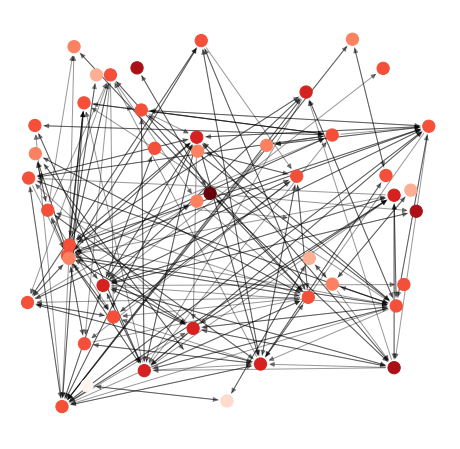

In [ ]:
# find node near center (0.5,0.5)
dmin = 1
ncenter = 0
for n in pos:
    x, y = pos[n]
    d = (x - 0.5)**2 + (y - 0.5)**2
    if d < dmin:
        ncenter = n
        dmin = d

# color by path length from node near center
p = dict(nx.single_source_shortest_path_length(sub, ncenter))

plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(sub, pos, nodelist=[ncenter], alpha=0.4)
nx.draw_networkx_nodes(sub, pos, nodelist=list(p.keys()),
                       node_size=150,
                       node_color=list(p.values()),
                       cmap=plt.cm.Reds_r)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.axis('off')
plt.show()

the centered node is purple, the farther an other node, the lighter its color

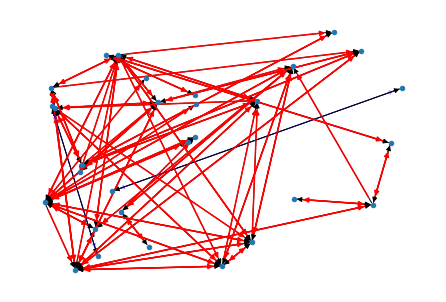

In [ ]:
sub = graph.subgraph( list(graph.nodes())[ :30 ] )
pos = nx.random_layout(sub, dim=2, seed=1)

import math

# This example needs Graphviz and either PyGraphviz or pydot.
from networkx.drawing.nx_pydot import graphviz_layout as layout
#from networkx.drawing.nx_agraph import graphviz_layout as layout

plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.01, hspace=0.01)

nx.draw(sub, pos, with_labels=False, node_size=20)

# identify largest connected component
Gcc = sorted(nx.connected_components(sub.to_undirected()), key=len, reverse=True)
G0 = sub.subgraph(Gcc[0])
nx.draw_networkx_edges(G0, pos, edge_color="r", width=1.5)

# show other connected components
for Gi in Gcc[1:]:
    if len(Gi) > 1:
        nx.draw_networkx_edges(
            sub.subgraph(Gi), pos, edge_color="b", alpha=0.3, width=.5,
        )
plt.show()

###Graph Analysis

####Node degree

In [ ]:
def average_degree(num_edges, num_nodes):
  # TODO: Implement this function that takes number of edges
  # and number of nodes, and returns the average node degree of 
  # the graph. Round the result to nearest integer (for example 
  # 3.3 will be rounded to 3 and 3.7 will be rounded to 4)
  avg_degree = 0
  avg_degree = int(round(2*num_edges/num_nodes, 0))
  return avg_degree

num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
avg_degree = average_degree(num_edges, num_nodes)
print("Average degree of the network is {}".format(avg_degree))

Average degree of the network is 24


graph has 8343 nodes


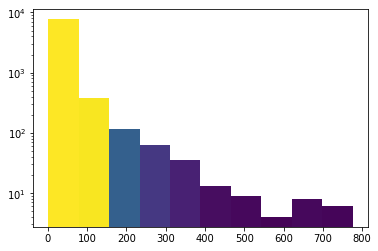

[1.0, 78.5, 156.0, 233.5, 311.0, 388.5, 466.0, 543.5, 621.0, 698.5, 776.0]
[7708, 382, 116, 62, 35, 13, 9, 4, 8, 6]


In [ ]:
print("graph has {} nodes".format(graph.number_of_nodes()))
plt.yscale('log') #value : {"linear", "log", "symlog", "logit", ...}
(n, bins, patches) = plt.hist([v for k,v in nx.degree(G)])
cmap = plt.cm.viridis
for i, (cnt, value, bar) in enumerate(zip(n, bins, patches)):
    bar.set_facecolor(cmap(cnt/(n.max()/20)))
plt.show()
print(list(bins))
print(list(map(int, n)))

####Centrality
(raw) Closeness centrality: \
A note is important if it has small shortest path lenghts to all other nodes \
i.e. the more centered the node, the shorter the path to others

Equation: $c(v) = \frac{1}{\sum_{u \neq v}\text{shortest path length between } u \text{ and } v}$

graph has 8343 nodes


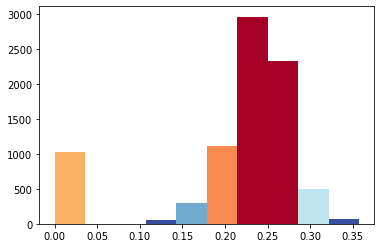

[0.0, 0.04, 0.07, 0.11, 0.14, 0.18, 0.21, 0.25, 0.29, 0.32, 0.36]
[1030, 0, 1, 51, 292, 1119, 2963, 2325, 500, 62]


In [ ]:
print("graph has {} nodes".format(graph.number_of_nodes()))
(n, bins, patches) = plt.hist(nx.centrality.closeness_centrality(G).values()) #networkx has normalized the results
cmap = plt.cm.get_cmap('RdYlBu_r')
for i, (cnt, value, bar) in enumerate(zip(n, bins, patches)):
    bar.set_facecolor(cmap(cnt/(n.max()/2)))
plt.show()
bins_round = [round(float(i), 2) for i in list(bins) ]
print(bins_round)
print(list(map(int, n)))

Most of the nodes(~70%) has closeness centrality in (0.2,0.3) indicates that most of the nodes influence its neighborhood similarly and the network seems to be highly connected

####Common neighbors

In [ ]:
common_cnt = []
G1 = G.to_undirected()
for edge in G1.edges():
  u = edge[0]
  v = edge[1]
  common_cnt.append(len(list(nx.common_neighbors(G1, u, v))))

In [ ]:
len(list(G1.edges()))

63913

In [ ]:
sum(i == 0 for i in common_cnt)

7020

In [ ]:
len(common_cnt)

63913

graph has 100000 edges


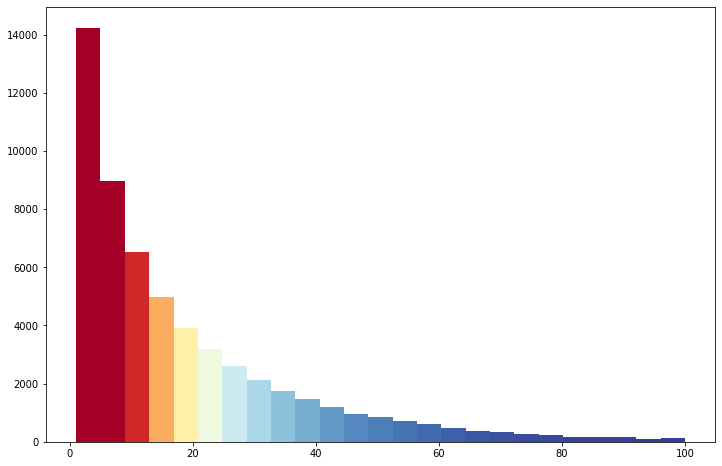

[1.0, 4.96, 8.92, 12.88, 16.84, 20.8, 24.76, 28.72, 32.68, 36.64, 40.6, 44.56, 48.52, 52.48, 56.44, 60.4, 64.36, 68.32, 72.28, 76.24, 80.2, 84.16, 88.12, 92.08, 96.04, 100.0]
[14239, 8954, 6530, 4979, 3898, 3179, 2613, 2126, 1760, 1461, 1186, 970, 859, 717, 599, 475, 375, 328, 269, 235, 156, 161, 148, 99, 118]


In [ ]:
print("graph has {} edges".format(G.number_of_edges()))
plt.figure(figsize=(12,8))
(n, bins, patches) = plt.hist(common_cnt, bins=25, range = (1,100)) 
cmap = plt.cm.get_cmap('RdYlBu_r')
for i, (cnt, value, bar) in enumerate(zip(n, bins, patches)):
    bar.set_facecolor(cmap(cnt/(n.max()/2)))
plt.show()
bins_round = [round(float(i), 2) for i in list(bins) ]
print(bins_round)
print(list(map(int, n)))

In [ ]:
?plt.hist

In [ ]:
print("graph has {} nodes".format(G.number_of_nodes()))

graph has 8343 nodes


Since there are 8343 nodes and 10000 edges, there are many edges (u,v) that u,v just share a few nodes in common

-> many outliers /local group

####Clustering coefficients
- Indicate the local structure/properties around a node i.e. its immediate vicinity
- Measure how connected a node's neighbors are

Equation: $e(v) = \frac{\text{#(edges among neighboring nodes)}}{\text{#(node pairs among neighboring nodes)} } \in [0,1]$ 


In [ ]:
def average_clustering_coefficient(G):
  # TODO: Implement this function that takes a nx.Graph
  # and returns the average clustering coefficient. Round 
  # the result to 2 decimal places (for example 3.333 will
  # be rounded to 3.33 and 3.7571 will be rounded to 3.76)
  avg_cluster_coef = 0

  avg_cluster_coef = round(sum(nx.clustering(G).values())/G.number_of_nodes(), 2)
  return avg_cluster_coef

avg_cluster_coef = average_clustering_coefficient(G)
print("Average clustering coefficient of the network is {}".format(avg_cluster_coef))

Average clustering coefficient of the network is 0.18


graph has 8343 nodes


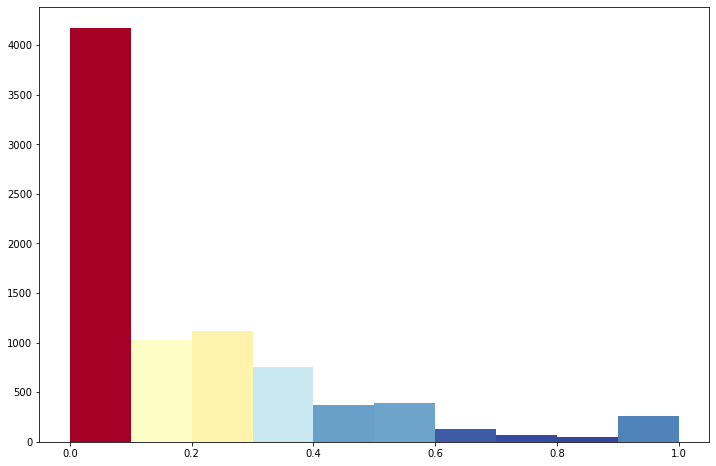

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
[4176, 1022, 1122, 750, 375, 390, 126, 66, 53, 263]


In [ ]:
print("graph has {} nodes".format(graph.number_of_nodes()))
plt.figure(figsize=(12,8))
(n, bins, patches) = plt.hist(nx.clustering(G).values())
cmap = plt.cm.get_cmap('RdYlBu_r')
for i, (cnt, value, bar) in enumerate(zip(n, bins, patches)):
    bar.set_facecolor(cmap(cnt/(n.max()/2)))
plt.show()
bins_round = [round(float(i), 2) for i in list(bins) ]
print(bins_round)
print(list(map(int, n)))

Most of the nodes (~50%) has clustering coefficients < 0.1 indicates that locally, a node's neighborhood seems to be not connected